In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import urllib
import requests
import zipfile
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
import geopandas as gpd
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_LL84(url):
    data = pd.read_excel(url)
    cols = [x.encode('utf8').replace('\xc2\xb2', '2') for x in data.columns]
    data.columns = cols
    data.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL',
                           'NYC Borough, Block and Lot (BBL)':'BBL','Zip Code':'Zip',
                           'Site EUI (kBtu/ft2)':'Site EUI',
        'Site EUI\n(kBtu/ft2)':'Site EUI','DOF Benchmarking Submission Status':'Benchmarking Submission',
                           'Weather Normalized Source EUI\n(kBtu/ft2)':'Weather Normalized Source EUI',
                           'Weather Normalized Source EUI (kBtu/ft2)':'Weather Normalized Source EUI',
                           'Municipally Supplied Potable Water - Indoor Intensity (gal/ft2)':'Indoor Water Intensity(gal/ft2)',
                           'Indoor Water Intensity (All Water Sources)\n(gal/ft2)':'Indoor Water Intensity(gal/ft2)',
                           'Water per Square Foot':'Indoor Water Intensity(gal/ft2)',
                           'Total GHG Emissions\n(MtCO2e)':'GHG',
                           'Total GHG Emissions (Metric Tons CO2e)':'GHG',
                           'Municipally Supplied Potable Water - Indoor Intensity (gal/ft2)':'Indoor Water Intensity(gal/ft2)',
                               'Property Floor Area (Buildngs and Parking)\n(ft2)':'Property Floor Area(ft2)',
                           'DOF Property Floor Area (ft2)':'Property Floor Area(ft2)',
                               'DOF Property Floor Area (Buildngs and Parking)\n(ft2)':'Property Floor Area(ft2)',
                           'DOF Property Floor Area (ft²)':'Property Floor Area(ft2)',
                               'DOF Number of Buildings':'Number of Buildings',
                           'Number of Buildings - Self-reported':'Number of Buildings',
                          'Primary Property Type - Self Selected':'Reported Facility Type'},inplace=True)
    
    
    data = data[data['ENERGY STAR Score']>0][['BBL','ENERGY STAR Score','Property Floor Area(ft2)','Reported Facility Type']]
    return data

## Get LL84 data in year 2016

In [3]:
LL16 = get_LL84('http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx')

In [4]:
LL16.BBL = LL16.BBL.astype('str').str[:-2]

In [5]:
LL16 = LL16[LL16.BBL.str[0]=='3']

In [6]:
LL16.head(5)

,BBL,ENERGY STAR Score,Property Floor Area(ft2),Reported Facility Type
7366,3000180001,100.0,211386.0,Office
7367,3000190001,97.0,460000.0,Office
7369,3000270040,89.0,87129.0,Office
7370,3000277501,1.0,241434.0,Multifamily Housing
7372,3000287502,71.0,85477.0,Multifamily Housing


## Read the building price data

In [7]:
price = pd.read_csv('2016.csv')
price.head()

,﻿BBL,VALUE
0,1000010010,347802000
1,1000010101,27105000
2,1000010201,241001000
3,1000010301,0
4,1000010401,0


In [8]:
price.columns = [LL16.columns[0],'Price']

In [9]:
LL16.columns

Index([u'BBL', u'ENERGY STAR Score', u'Property Floor Area(ft2)',
       u'Reported Facility Type'],
      dtype='object')

## Merge building and its price

In [10]:
merged16 = pd.merge(LL16, price, on='BBL')

In [11]:
merged16 = merged16[merged16['Price']>0]

In [12]:
merged16 = merged16.dropna(axis=0)

In [13]:
merged16.columns = [x.replace(' ','_') for x in merged16.columns]

In [14]:
# calculate price per square footage
merged16['Price'] = merged16['Price']/merged16['Property_Floor_Area(ft2)']

In [15]:
merged16.head()

,BBL,ENERGY_STAR_Score,Property_Floor_Area(ft2),Reported_Facility_Type,Price
0,3000180001,100.0,211386.0,Office,73.353959
1,3000190001,97.0,460000.0,Office,126.245652
2,3000270040,89.0,87129.0,Office,260.211870
7,3000360016,1.0,50932.0,Multifamily Housing,174.526820
9,3000370001,93.0,476000.0,Office,152.531513


In [16]:
merged16.reset_index(inplace=True)

In [17]:
merged16.head()

,index,BBL,ENERGY_STAR_Score,Property_Floor_Area(ft2),Reported_Facility_Type,Price
0,0,3000180001,100.0,211386.0,Office,73.353959
1,1,3000190001,97.0,460000.0,Office,126.245652
2,2,3000270040,89.0,87129.0,Office,260.211870
3,7,3000360016,1.0,50932.0,Multifamily Housing,174.526820
4,9,3000370001,93.0,476000.0,Office,152.531513


In [18]:
merged16.BBL.describe()

count           1720
unique          1720
top       3053570030
freq               1
Name: BBL, dtype: object

In [19]:
del merged16['index']
merged16.head()

,BBL,ENERGY_STAR_Score,Property_Floor_Area(ft2),Reported_Facility_Type,Price
0,3000180001,100.0,211386.0,Office,73.353959
1,3000190001,97.0,460000.0,Office,126.245652
2,3000270040,89.0,87129.0,Office,260.211870
3,3000360016,1.0,50932.0,Multifamily Housing,174.526820
4,3000370001,93.0,476000.0,Office,152.531513


In [20]:
del merged16['Property_Floor_Area(ft2)']
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price
0,3000180001,100.0,Office,73.353959
1,3000190001,97.0,Office,126.245652
2,3000270040,89.0,Office,260.211870
3,3000360016,1.0,Multifamily Housing,174.526820
4,3000370001,93.0,Office,152.531513


## Get the match form of BBL and tract(GEOID)

In [21]:
match = pd.read_csv('match.csv')
match.head()

,Unnamed: 0,BBL,Tract2010,Borough,Block,Lot,BoroCode,BldgArea,XCoord,YCoord,YearBuilt,CondoNo,OwnerType,NumFloors,UnitsRes,UnitsTotal
0,0,3000010001,2100,BK,1,1,3,0,NaN,NaN,0,0,P,0.0,0,0
1,1,3000010050,2100,BK,1,50,3,154400,987838.0,195989.0,1920,0,NaN,9.0,0,90
2,2,3000017501,2100,BK,1,7501,3,102534,987624.0,195992.0,0,3819,NaN,12.0,42,44
3,3,3000030001,2100,BK,3,1,3,0,988568.0,196151.0,0,0,NaN,0.0,0,0
4,4,3000030005,2100,BK,3,5,3,0,NaN,NaN,0,0,C,0.0,0,0


In [22]:
# get tract's GEOID
match.loc[:, 'GEOID']=['36047'+str(i).zfill(6) for i in list(match.Tract2010)]

In [23]:
match = match[['BBL','GEOID']]

In [24]:
match.BBL = match.BBL.astype(str)

In [25]:
match.BBL.describe()

count         276491
unique        276491
top       3082570060
freq               1
Name: BBL, dtype: object

## Merge building and its tract

In [26]:
merged16 = pd.merge(merged16,match, on='BBL')

In [27]:
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price,GEOID
0,3000180001,100.0,Office,73.353959,36047002100
1,3000190001,97.0,Office,126.245652,36047002100
2,3000270040,89.0,Office,260.211870,36047002100
3,3000360016,1.0,Multifamily Housing,174.526820,36047002100
4,3000370001,93.0,Office,152.531513,36047002100


In [28]:
merged16.shape

(1720, 5)

## Load the whole NYC shapefile

In [29]:
census = gpd.GeoDataFrame.from_file('cb_2016_36_tract_500k.shp')
census = census[['GEOID','geometry']]
census.head()

,GEOID,geometry
0,36051031000,"POLYGON ((-77.841638 42.671857, -77.841531 42...."
1,36053030102,"POLYGON ((-75.69125 43.09777099999999, -75.686..."
2,36055000200,"POLYGON ((-77.63571399999999 43.17025, -77.632..."
3,36055001000,"POLYGON ((-77.592748 43.158266, -77.5916189999..."
4,36055002900,"POLYGON ((-77.59551499999999 43.152906, -77.59..."


In [30]:
census.crs

{'init': u'epsg:4269'}

## Read crime data of NYC

In [31]:
crime = zipfile.ZipFile('crime.zip')
crime.extractall()
crime = pd.read_csv('crime.csv')
crime.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,155423129,12/31/2016,23:40:00,12/31/2016,23:50:00,12/31/2016,105,ROBBERY,389.0,"ROBBERY,DWELLING",COMPLETED,FELONY,N.Y. POLICE DEPT,BRONX,43,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1021170.0,241240.0,40.828755,-73.866594,"(40.828754623, -73.866593516)"
1,225104473,12/31/2016,23:24:00,12/31/2016,23:30:00,12/31/2016,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",COMPLETED,FELONY,N.Y. POLICE DEPT,QUEENS,102,NaN,STREET,NaN,NaN,1026086.0,192340.0,40.694515,-73.849134,"(40.694514975, -73.849134227)"
2,428909890,12/31/2016,23:20:00,12/31/2016,23:25:00,12/31/2016,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,70,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,995108.0,175859.0,40.649371,-73.960872,"(40.649370541, -73.960872294)"
3,816766111,12/31/2016,23:19:00,NaN,NaN,12/31/2016,126,MISCELLANEOUS PENAL LAW,198.0,CRIMINAL CONTEMPT 1,COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,13,NaN,STREET,NaN,NaN,989083.0,205732.0,40.731370,-73.982563,"(40.73137039, -73.982563257)"
4,100511069,12/31/2016,23:00:00,NaN,NaN,12/31/2016,109,GRAND LARCENY,415.0,"LARCENY,GRAND FROM PERSON,PICK",COMPLETED,FELONY,N.Y. POLICE DEPT,MANHATTAN,18,INSIDE,BAR/NIGHT CLUB,NaN,NaN,988149.0,216376.0,40.760586,-73.985927,"(40.760585967, -73.9859271)"


In [32]:
crime.columns

Index([u'CMPLNT_NUM', u'CMPLNT_FR_DT', u'CMPLNT_FR_TM', u'CMPLNT_TO_DT',
       u'CMPLNT_TO_TM', u'RPT_DT', u'KY_CD', u'OFNS_DESC', u'PD_CD',
       u'PD_DESC', u'CRM_ATPT_CPTD_CD', u'LAW_CAT_CD', u'JURIS_DESC',
       u'BORO_NM', u'ADDR_PCT_CD', u'LOC_OF_OCCUR_DESC', u'PREM_TYP_DESC',
       u'PARKS_NM', u'HADEVELOPT', u'X_COORD_CD', u'Y_COORD_CD', u'Latitude',
       u'Longitude', u'Lat_Lon'],
      dtype='object')

In [33]:
# limit the area in Brooklyn
crime = crime[crime['BORO_NM']=='BROOKLYN']
crime = crime[['Latitude','Longitude']]
crime.head()

,Latitude,Longitude
2,40.649371,-73.960872
10,40.637285,-73.952383
16,40.595038,-73.954736
22,40.597918,-73.997999
23,40.644918,-73.921918


In [34]:
crime = crime.dropna(axis=0,how='any')
crime.reset_index(inplace=True)
del crime['index']
crime.head()

,Latitude,Longitude
0,40.649371,-73.960872
1,40.637285,-73.952383
2,40.595038,-73.954736
3,40.597918,-73.997999
4,40.644918,-73.921918


## Count crime complaints in each tract

In [35]:
from shapely.geometry import Point
crime['geometry'] = crime.apply(lambda z: Point(z['Longitude'], z['Latitude']), axis=1)
crime = gpd.GeoDataFrame(crime['geometry'])
crime.crs = census.crs
crime.head()

,geometry
0,POINT (-73.960872294 40.649370541)
1,POINT (-73.95238335499999 40.637284793)
2,POINT (-73.954735986 40.595037877)
3,POINT (-73.997999318 40.597917833)
4,POINT (-73.921917722 40.644917864)


In [36]:
from geopandas.tools import sjoin
pointInPolys1 = sjoin(crime, census, how='left')

In [37]:
crime = pointInPolys1.groupby('GEOID').count()
crime.reset_index(inplace=True)
crime.head()

,GEOID,geometry,index_right
0,36005000100,57,57
1,36047000100,28,28
2,36047000200,38,38
3,36047000301,35,35
4,36047000501,32,32


In [38]:
del crime['index_right']
crime.columns=[['GEOID','Crime']]
crime.head()

,GEOID,Crime
0,36005000100,57
1,36047000100,28
2,36047000200,38
3,36047000301,35
4,36047000501,32


## Merge building and its crime data

In [39]:
merged16 = pd.merge(merged16,crime,on=['GEOID'])
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price,GEOID,Crime
0,3000180001,100.0,Office,73.353959,36047002100,117
1,3000190001,97.0,Office,126.245652,36047002100,117
2,3000270040,89.0,Office,260.211870,36047002100,117
3,3000360016,1.0,Multifamily Housing,174.526820,36047002100,117
4,3000370001,93.0,Office,152.531513,36047002100,117


## Read ACS data

In [40]:
acs2016 = pd.read_csv('acs2016.csv')

In [41]:
acs2016.head()

,Unnamed: 0,GEOID,Pop_Den_16,Median_Household_Income_16,Gini_Index_16,Ave_Commute_Min_16,Unemployed_rate_16,Moved_in_4years_16
0,0,36005000100,12304.140706,0.0,0.0000,NaN,NaN,0.000000
1,1,36005000200,29869.031039,70893.0,0.4021,43.997208,0.067579,0.000000
2,2,36005000400,16975.281736,76667.0,0.3636,48.388218,0.089706,0.000000
3,3,36005001600,32334.871893,31540.0,0.4343,35.779286,0.084359,0.004317
4,4,36005001900,4226.161844,39130.0,0.4626,43.829982,0.162953,0.017332


In [42]:
acs2016 = acs2016[['GEOID','Pop_Den_16','Median_Household_Income_16']]
acs2016.columns = [['GEOID','Density','Income']]
acs2016.head()

,GEOID,Density,Income
0,36005000100,12304.140706,0.0
1,36005000200,29869.031039,70893.0
2,36005000400,16975.281736,76667.0
3,36005001600,32334.871893,31540.0
4,36005001900,4226.161844,39130.0


In [43]:
acs2016.GEOID = acs2016.GEOID.astype(str)
acs2016.GEOID.describe()

count            2167
unique           2167
top       36081064600
freq                1
Name: GEOID, dtype: object

In [44]:
acs2016.head()

,GEOID,Density,Income
0,36005000100,12304.140706,0.0
1,36005000200,29869.031039,70893.0
2,36005000400,16975.281736,76667.0
3,36005001600,32334.871893,31540.0
4,36005001900,4226.161844,39130.0


In [45]:
# Remove useless data
acs2016 = acs2016[acs2016['Density']>0]
acs2016 = acs2016[acs2016['Income']>0]

## Merge building and its ACS related data

In [46]:
merged16 = pd.merge(merged16,acs2016,on=['GEOID'])
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price,GEOID,Crime,Density,Income
0,3000180001,100.0,Office,73.353959,36047002100,117,24236.770456,211071.0
1,3000190001,97.0,Office,126.245652,36047002100,117,24236.770456,211071.0
2,3000270040,89.0,Office,260.211870,36047002100,117,24236.770456,211071.0
3,3000360016,1.0,Multifamily Housing,174.526820,36047002100,117,24236.770456,211071.0
4,3000370001,93.0,Office,152.531513,36047002100,117,24236.770456,211071.0


In [47]:
del merged16['GEOID']
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price,Crime,Density,Income
0,3000180001,100.0,Office,73.353959,117,24236.770456,211071.0
1,3000190001,97.0,Office,126.245652,117,24236.770456,211071.0
2,3000270040,89.0,Office,260.211870,117,24236.770456,211071.0
3,3000360016,1.0,Multifamily Housing,174.526820,117,24236.770456,211071.0
4,3000370001,93.0,Office,152.531513,117,24236.770456,211071.0


## Get Pluto data

In [48]:
urllib.urlretrieve('http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip','pluto.zip')
pluto = zipfile.ZipFile('pluto.zip')
pluto.extractall()


In [49]:
pluto = pd.read_csv('BORO_zip_files_csv/BK.csv')
pluto.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19,21,22,23,24,25,63,64,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,...,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version
0,BK,1,1,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JOHN STREET,M3-1,M1-4/R8A,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,...,0,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3000010001,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,3.000010e+09,11/26/2013,1,16V2
1,BK,1,50,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,10 JAY STREET,M1-4/R8A,M3-1,NaN,NaN,NaN,NaN,MX-2,NaN,NaN,...,290250,1920,1994,2007,DUMBO Historic District,NaN,7.84,5.4,2.0,6.5,3,3000010050,0,21,987838.0,195989.0,12d,NaN,302 007,30101.0,E-231,0.000000e+00,NaN,1,16V2
2,BK,1,7501,302,21.0,2000.0,13.0,33.0,11201.0,L118,84.0,1000.0,1.0,2.0,NaN,1 JOHN STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3000017501,3819,21,987624.0,195992.0,12d,NaN,302 007,30101.0,NaN,3.000010e+09,3/4/2016,1,16V2
3,BK,3,1,302,21.0,3002.0,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,0.00,0.0,2.0,0.0,3,3000030001,0,21,988568.0,196151.0,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,1,16V2
4,BK,3,5,302,21.0,NaN,13.0,33.0,11201.0,L118,84.0,1000.0,3.0,2.0,1B,JAY STREET,M3-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21150,0,0,0,DUMBO Historic District,NaN,0.00,0.0,2.0,0.0,3,3000030005,0,21,NaN,NaN,12d,NaN,302 007,30101.0,NaN,0.000000e+00,NaN,4,16V2


In [50]:
pluto = pluto[['NumFloors','YearBuilt','BBL']]

In [51]:
pluto = pluto[(pluto != 0).all(1)]

In [52]:
pluto.BBL = pluto.BBL.astype('str')

In [53]:
pluto.head()

,NumFloors,YearBuilt,BBL
1,9.0,1920,3000010050
17,1.0,1988,3000070021
20,1.0,1920,3000160005
22,7.0,1900,3000180001
23,11.0,1911,3000190001


## Merge building and its Pluto related data

In [54]:
merged16 = pd.merge(merged16,pluto,on='BBL')

In [55]:
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price,Crime,Density,Income,NumFloors,YearBuilt
0,3000180001,100.0,Office,73.353959,117,24236.770456,211071.0,7.0,1900
1,3000190001,97.0,Office,126.245652,117,24236.770456,211071.0,11.0,1911
2,3000270040,89.0,Office,260.211870,117,24236.770456,211071.0,7.0,1930
3,3000360016,1.0,Multifamily Housing,174.526820,117,24236.770456,211071.0,5.0,1910
4,3000370001,93.0,Office,152.531513,117,24236.770456,211071.0,12.0,1906


In [56]:
# calculate building age
merged16['Age'] = 2017-merged16['YearBuilt']

In [57]:
del merged16['YearBuilt']
merged16.head()

,BBL,ENERGY_STAR_Score,Reported_Facility_Type,Price,Crime,Density,Income,NumFloors,Age
0,3000180001,100.0,Office,73.353959,117,24236.770456,211071.0,7.0,117
1,3000190001,97.0,Office,126.245652,117,24236.770456,211071.0,11.0,106
2,3000270040,89.0,Office,260.211870,117,24236.770456,211071.0,7.0,87
3,3000360016,1.0,Multifamily Housing,174.526820,117,24236.770456,211071.0,5.0,107
4,3000370001,93.0,Office,152.531513,117,24236.770456,211071.0,12.0,111


In [58]:
merged16.describe()

,ENERGY_STAR_Score,Price,Crime,Density,Income,NumFloors,Age
count,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000,1707.000000
mean,63.786760,74.195097,61.928530,61019.581167,54373.648506,6.816052,69.567663
std,28.111781,56.170195,45.578959,29954.619431,25631.000440,4.147786,23.851914
min,1.000000,13.429100,1.000000,864.344712,11444.000000,1.000000,3.000000
25%,45.000000,44.780230,29.000000,41834.241041,40092.000000,6.000000,56.000000
50%,70.000000,57.230367,47.000000,56417.029772,50250.000000,6.000000,77.000000
75%,87.000000,79.084479,88.000000,74316.759744,61188.000000,6.000000,87.000000
max,100.000000,643.462069,273.000000,154339.700022,211071.000000,51.000000,123.000000


## Crime complaints plot

In [59]:
crime1 = gpd.GeoDataFrame(crime)

In [60]:
crime1.head()

,GEOID,Crime
0,36005000100,57
1,36047000100,28
2,36047000200,38
3,36047000301,35
4,36047000501,32


In [61]:
census1 = crime1.merge(census,on='GEOID',how='inner')

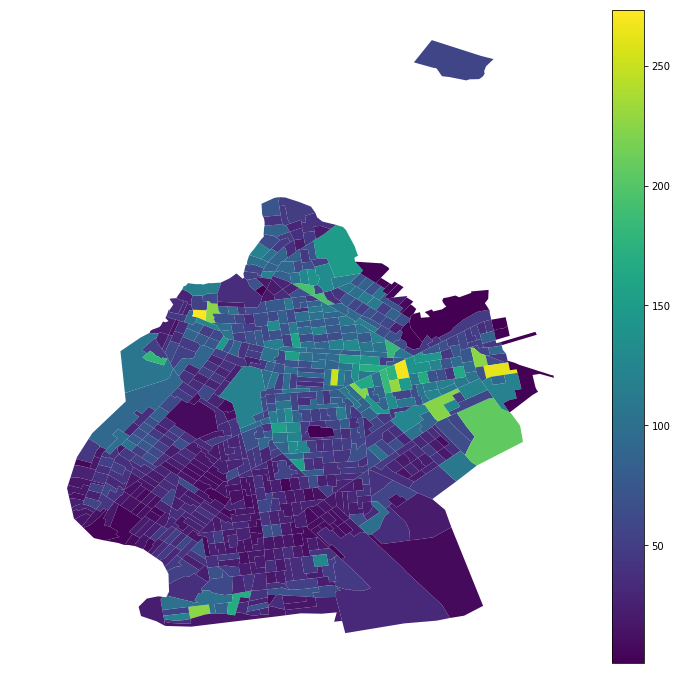

In [62]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.axis('off')
census1.plot(column='Crime', ax=ax,legend=True)
plt.show()

## BBL Map plot

In [63]:
urllib.urlretrieve('https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/bk_mappluto_16v2.zip','map.zip')
Map = zipfile.ZipFile('map.zip')
Map.extractall()

In [64]:
Map = gpd.GeoDataFrame.from_file('BKMapPLUTO.shp')
Map.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,...,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,BK,7036,23,313,336,None,21,47,11224,E318,60,9010,3,13,2D,BEACH RESERVATION,R3-1,None,None,None,None,None,None,None,None,...,None,None,0.00,0.60,0.0,1.0,3,3.070360e+09,0,0336,0,0,28b,None,318 082,32104,None,0.000000e+00,None,1,16V2,0,1008.659562,48254.897890,"POLYGON ((980812.9622000009 149656.1661999971,..."
1,BK,7037,45,313,336,None,21,47,11224,E318,60,9010,3,13,2D,BEACH 46 STREET,R3-1,None,None,None,None,None,None,None,None,...,None,None,0.00,0.60,0.0,1.0,3,3.070370e+09,0,0336,0,0,28b,None,318 082,32104,None,0.000000e+00,None,1,16V2,0,466.778463,12182.420391,"POLYGON ((980811.0732000023 149338.8654000014,..."
2,BK,8696,70,313,352,1002,21,47,11224,E245,60,9020,3,13,2B,JONES WALK,C7,None,None,None,None,None,CI,None,None,...,None,None,0.00,0.00,2.0,0.0,3,3.086960e+09,0,0352,990121,148530,28d,None,318 058,32601,None,0.000000e+00,None,1,16V2,0,489.556780,2235.111932,"POLYGON ((990137.3931999952 148647.5088, 99011..."
3,BK,7029,84,313,336,2004,21,47,11224,E318,60,9010,3,13,2C,3753 MERMAID AVENUE,R3-1,None,None,None,None,None,None,None,None,...,None,None,0.90,0.60,0.0,1.0,3,3.070290e+09,0,0336,982905,148690,28b,None,318 085,32104,None,0.000000e+00,None,1,16V2,0,260.717734,3979.291146,"POLYGON ((982935.4722000062 148654.2924000025,..."
4,BK,7049,115,313,342,3000,21,47,11224,E318,60,9010,3,13,2B,3102 MERMAID AVENUE,R6,None,None,None,C1-2,None,None,None,None,...,None,None,1.02,2.43,0.0,4.8,3,3.070490e+09,0,0342,984915,148767,28d,None,318 076,32104,None,3.070490e+09,12/19/2000,1,16V2,0,181.786006,1683.769587,"POLYGON ((984932.7683999985 148737.0093999952,..."


In [65]:
Map['Borough'] = '3'
Map['Block'] = [str(i).zfill(5) for i in list(Map.Block)]
Map['Lot'] = [str(i).zfill(4) for i in list(Map.Lot)]
Map['BBL'] = Map['Borough']+Map['Block']+Map['Lot']
Map.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthArea,SanitBoro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,...,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,3,07036,0023,313,336,None,21,47,11224,E318,60,9010,3,13,2D,BEACH RESERVATION,R3-1,None,None,None,None,None,None,None,None,...,None,None,0.00,0.60,0.0,1.0,3,3070360023,0,0336,0,0,28b,None,318 082,32104,None,0.000000e+00,None,1,16V2,0,1008.659562,48254.897890,"POLYGON ((980812.9622000009 149656.1661999971,..."
1,3,07037,0045,313,336,None,21,47,11224,E318,60,9010,3,13,2D,BEACH 46 STREET,R3-1,None,None,None,None,None,None,None,None,...,None,None,0.00,0.60,0.0,1.0,3,3070370045,0,0336,0,0,28b,None,318 082,32104,None,0.000000e+00,None,1,16V2,0,466.778463,12182.420391,"POLYGON ((980811.0732000023 149338.8654000014,..."
2,3,08696,0070,313,352,1002,21,47,11224,E245,60,9020,3,13,2B,JONES WALK,C7,None,None,None,None,None,CI,None,None,...,None,None,0.00,0.00,2.0,0.0,3,3086960070,0,0352,990121,148530,28d,None,318 058,32601,None,0.000000e+00,None,1,16V2,0,489.556780,2235.111932,"POLYGON ((990137.3931999952 148647.5088, 99011..."
3,3,07029,0084,313,336,2004,21,47,11224,E318,60,9010,3,13,2C,3753 MERMAID AVENUE,R3-1,None,None,None,None,None,None,None,None,...,None,None,0.90,0.60,0.0,1.0,3,3070290084,0,0336,982905,148690,28b,None,318 085,32104,None,0.000000e+00,None,1,16V2,0,260.717734,3979.291146,"POLYGON ((982935.4722000062 148654.2924000025,..."
4,3,07049,0115,313,342,3000,21,47,11224,E318,60,9010,3,13,2B,3102 MERMAID AVENUE,R6,None,None,None,C1-2,None,None,None,None,...,None,None,1.02,2.43,0.0,4.8,3,3070490115,0,0342,984915,148767,28d,None,318 076,32104,None,3.070490e+09,12/19/2000,1,16V2,0,181.786006,1683.769587,"POLYGON ((984932.7683999985 148737.0093999952,..."


In [66]:
Map.shape

(276909, 88)

In [67]:
Map1=Map[['BBL','geometry']]
Map1.head()

,BBL,geometry
0,3070360023,"POLYGON ((980812.9622000009 149656.1661999971,..."
1,3070370045,"POLYGON ((980811.0732000023 149338.8654000014,..."
2,3086960070,"POLYGON ((990137.3931999952 148647.5088, 99011..."
3,3070290084,"POLYGON ((982935.4722000062 148654.2924000025,..."
4,3070490115,"POLYGON ((984932.7683999985 148737.0093999952,..."


In [68]:
matchbbl = gpd.GeoDataFrame(merged16.BBL)
matchbbl.head()

,BBL
0,3000180001
1,3000190001
2,3000270040
3,3000360016
4,3000370001


In [69]:
Map1 = Map1.merge(matchbbl,on='BBL')
Map1.head()

,BBL,geometry
0,3070550013,"POLYGON ((986467.6878000051 148924.070600003, ..."
1,3070520034,"POLYGON ((985912.3317999989 148192.7502000034,..."
2,3070520014,"POLYGON ((985851.1231999993 148613.830400005, ..."
3,3070490051,"POLYGON ((984933.8268000036 147993.7585999966,..."
4,3070700001,"POLYGON ((986897.7689999938 147623.9223999977,..."


In [70]:
Map1.shape

(1706, 2)

In [71]:
Map1.crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

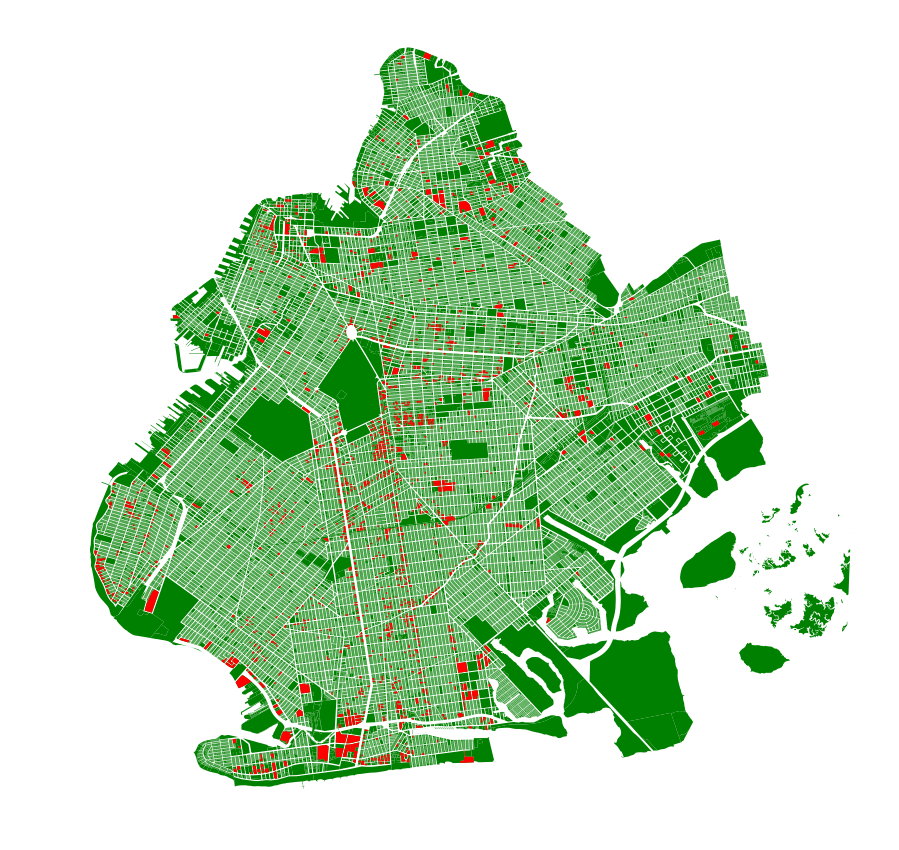

In [72]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.axis('off')
Map.plot(column=None, ax=ax, color="green")
Map1.plot(column=None, ax=ax, color="red",legend=True)
plt.show()

## Normalization

In [73]:
del merged16['BBL']

In [74]:
columns = ['ENERGY_STAR_Score']+list(merged16.columns[2:])

In [75]:
def norm(data,columns):
    for x in columns:
        data[x] = (data[x]-np.min(data[x]))/(np.max(data[x])-np.min(data[x]))
    return data

In [76]:
merged16 = norm(merged16,columns)
merged16.head()

,ENERGY_STAR_Score,Reported_Facility_Type,Price,Crime,Density,Income,NumFloors,Age
0,1.000000,Office,0.095114,0.426471,0.152288,1.0,0.12,0.950000
1,0.969697,Office,0.179065,0.426471,0.152288,1.0,0.20,0.858333
2,0.888889,Office,0.391698,0.426471,0.152288,1.0,0.12,0.700000
3,0.000000,Multifamily Housing,0.255697,0.426471,0.152288,1.0,0.08,0.866667
4,0.929293,Office,0.220786,0.426471,0.152288,1.0,0.22,0.900000


## Outliers are removed basically since they are outside the range of mean +- 2*std under the circumstance that they are already normalized.

In [77]:
def clean(data,columns):
    for x in columns:
        data = data[(data[x]<np.mean(data[x])+2*np.std(data[x]))&(data[x]>np.mean(data[x])-2*np.std(data[x]))]
    return data

In [78]:
merged16 = clean(merged16,columns)
merged16.head()

,ENERGY_STAR_Score,Reported_Facility_Type,Price,Crime,Density,Income,NumFloors,Age
43,0.383838,Multifamily Housing,0.160166,0.099265,0.313394,0.379448,0.12,0.625000
48,0.949495,Multifamily Housing,0.139914,0.356618,0.221856,0.206946,0.18,0.483333
49,0.656566,Multifamily Housing,0.141543,0.356618,0.221856,0.206946,0.22,0.541667
53,0.404040,Multifamily Housing,0.192744,0.312500,0.285303,0.339508,0.18,0.750000
54,0.626263,Multifamily Housing,0.191457,0.312500,0.285303,0.339508,0.14,0.908333


In [79]:
merged16.columns = [['score','type','price','crime','density','income','floors','age']]
merged16.head()

,score,type,price,crime,density,income,floors,age
43,0.383838,Multifamily Housing,0.160166,0.099265,0.313394,0.379448,0.12,0.625000
48,0.949495,Multifamily Housing,0.139914,0.356618,0.221856,0.206946,0.18,0.483333
49,0.656566,Multifamily Housing,0.141543,0.356618,0.221856,0.206946,0.22,0.541667
53,0.404040,Multifamily Housing,0.192744,0.312500,0.285303,0.339508,0.18,0.750000
54,0.626263,Multifamily Housing,0.191457,0.312500,0.285303,0.339508,0.14,0.908333


In [80]:
merged16.reset_index(inplace=True)
merged16.head()

,index,score,type,price,crime,density,income,floors,age
0,43,0.383838,Multifamily Housing,0.160166,0.099265,0.313394,0.379448,0.12,0.625000
1,48,0.949495,Multifamily Housing,0.139914,0.356618,0.221856,0.206946,0.18,0.483333
2,49,0.656566,Multifamily Housing,0.141543,0.356618,0.221856,0.206946,0.22,0.541667
3,53,0.404040,Multifamily Housing,0.192744,0.312500,0.285303,0.339508,0.18,0.750000
4,54,0.626263,Multifamily Housing,0.191457,0.312500,0.285303,0.339508,0.14,0.908333


In [81]:
del merged16['index']
merged16.head()

,score,type,price,crime,density,income,floors,age
0,0.383838,Multifamily Housing,0.160166,0.099265,0.313394,0.379448,0.12,0.625000
1,0.949495,Multifamily Housing,0.139914,0.356618,0.221856,0.206946,0.18,0.483333
2,0.656566,Multifamily Housing,0.141543,0.356618,0.221856,0.206946,0.22,0.541667
3,0.404040,Multifamily Housing,0.192744,0.312500,0.285303,0.339508,0.18,0.750000
4,0.626263,Multifamily Housing,0.191457,0.312500,0.285303,0.339508,0.14,0.908333


In [82]:
merged16.describe()

,score,price,crime,density,income,floors,age
count,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000,1217.000000
mean,0.679656,0.072793,0.182603,0.394338,0.195495,0.097535,0.602109
std,0.245412,0.039957,0.116574,0.172502,0.078607,0.022031,0.128000
min,0.070707,0.000000,0.014706,0.019189,0.028548,0.000000,0.233333
25%,0.515152,0.047230,0.095588,0.271029,0.143948,0.100000,0.483333
50%,0.737374,0.064433,0.150735,0.377549,0.189739,0.100000,0.633333
75%,0.878788,0.086360,0.238971,0.487070,0.245002,0.100000,0.708333
max,1.000000,0.265582,0.511029,0.799007,0.446367,0.220000,0.925000


## Normal linear regression

In [83]:
lm_no_energy = smf.ols(formula='price~C(type)+crime+density+income+floors+age',data=merged16).fit()
lm_no_energy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     20.83
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           3.66e-64
Time:                        22:47:52   Log-Likelihood:                 2374.2
No. Observations:                1217   AIC:                            -4706.
Df Residuals:                    1196   BIC:                            -4599.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.0764      0.036      2.126      0.034         0.006     0.147
C(type)[T.Distribution Center]                       0.0145      0.037      0.393      0.694        -0.058     0.087
C(type)[T.Hospital (General Medical & Surgical)]     0.0682      0.038      1.785      0.075        -0.007     0.143
C(type)[T.Hotel]                                     0.1765      0.049      3.579      0.000         0.080     0.273
C(type)[T.K-12 School]                               0.0713      0.037      1.940      0.053        -0.001     0.143
C(type)[T.Mixed Use Property]                        0.0778      0.049      1.583      0.114        -0.019     0.174
C(type)[T.Multifamily Housing]                      -0.0211      0.035     -0.605      0.545        -0.090     0.047
C(type)[T.Non-Refrigerated Warehouse]               -0.0092      0.036     -0.257      0.797        -0.079     0.061
C(type)[T.Office]                                    0.0171      0.036      0.478      0.633        -0.053     0.087
C(type)[T.Other]                                    -0.0160      0.049     -0.325      0.746        -0.113     0.081
C(type)[T.Refrigerated Warehouse]                   -0.0156      0.040     -0.388      0.698        -0.095     0.063
C(type)[T.Residence Hall/Dormitory]                  0.0397      0.049      0.807      0.420        -0.057     0.136
C(type)[T.Retail Store]                              0.0605      0.040      1.503      0.133        -0.018     0.139
C(type)[T.Senior Care Community]                     0.0739      0.037      1.976      0.048         0.001     0.147
C(type)[T.Supermarket/Grocery Store]                 0.0251      0.049      0.509      0.611        -0.072     0.122
C(type)[T.Worship Facility]                          0.1169      0.043      2.743      0.006         0.033     0.201
crime                                                0.0227      0.009      2.452      0.014         0.005     0.041
density                                             -0.0233      0.007     -3.306      0.001        -0.037    -0.009
income                                               0.0932      0.014      6.672      0.000         0.066     0.121
floors                                               0.2759      0.056      4.967      0.000         0.167     0.385
age                                                 -0.0431      0.008     -5.247      0.000        -0.059    -0.027
==============================================================================
Omnibus:                      293.060   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              840.977
Skew:                           1.217 

In [84]:
lm_with_energy = smf.ols(formula='price~C(type)+score+crime+density+income+floors+age',data=merged16).fit()
lm_with_energy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     20.62
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           4.63e-66
Time:                        22:47:52   Log-Likelihood:                 2380.5
No. Observations:                1217   AIC:                            -4717.
Df Residuals:                    1195   BIC:                            -4605.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            0.0784      0.036      2.194      0.028         0.008     0.149
C(type)[T.Distribution Center]                       0.0195      0.037      0.531      0.595        -0.053     0.092
C(type)[T.Hospital (General Medical & Surgical)]     0.0755      0.038      1.983      0.048         0.001     0.150
C(type)[T.Hotel]                                     0.1875      0.049      3.812      0.000         0.091     0.284
C(type)[T.K-12 School]                               0.0770      0.037      2.104      0.036         0.005     0.149
C(type)[T.Mixed Use Property]                        0.0757      0.049      1.548      0.122        -0.020     0.172
C(type)[T.Multifamily Housing]                      -0.0151      0.035     -0.433      0.665        -0.083     0.053
C(type)[T.Non-Refrigerated Warehouse]               -0.0027      0.036     -0.075      0.940        -0.073     0.067
C(type)[T.Office]                                    0.0252      0.036      0.707      0.480        -0.045     0.095
C(type)[T.Other]                                    -0.0054      0.049     -0.110      0.913        -0.102     0.091
C(type)[T.Refrigerated Warehouse]                   -0.0106      0.040     -0.263      0.793        -0.089     0.068
C(type)[T.Residence Hall/Dormitory]                  0.0381      0.049      0.778      0.437        -0.058     0.134
C(type)[T.Retail Store]                              0.0673      0.040      1.679      0.093        -0.011     0.146
C(type)[T.Senior Care Community]                     0.0790      0.037      2.123      0.034         0.006     0.152
C(type)[T.Supermarket/Grocery Store]                 0.0365      0.049      0.742      0.458        -0.060     0.133
C(type)[T.Worship Facility]                          0.1268      0.043      2.982      0.003         0.043     0.210
score                                               -0.0145      0.004     -3.524      0.000        -0.023    -0.006
crime                                                0.0204      0.009      2.202      0.028         0.002     0.039
density                                             -0.0240      0.007     -3.428      0.001        -0.038    -0.010
income                                               0.0937      0.014      6.740      0.000         0.066     0.121
floors                                               0.2822      0.055      5.102      0.000         0.174     0.391
age                                                 -0.0403      0.008     -4.896      0.000        -0.056    -0.024
==============================================================================
Omnibus:                      281.027   Durbin-Watson:                   1.584


In [85]:
anova = sm.stats.anova_lm(lm_no_energy,lm_with_energy)
anova

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1196.0,1.439784,0.0,NaN,NaN,NaN
1,1195.0,1.424976,1.0,0.014808,12.417883,0.000441


In [86]:
anova['Pr(>F)'][1] < 0.05

True

## Log-log Linear Regression

In [87]:
loglog = merged16.copy()

In [88]:
merged16.columns

Index([u'score', u'type', u'price', u'crime', u'density', u'income', u'floors',
       u'age'],
      dtype='object')

In [89]:
columns = [['score','price','crime','density','income','floors','age']]
for column in columns:
    loglog[column] = np.log(loglog[column])

## remove inf and 0

In [90]:
loglog = loglog.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [91]:
loglog.describe()

,score,price,crime,density,income,floors,age
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,-0.489979,-2.755486,-1.914692,-1.031507,-1.730203,-2.343928,-0.530899
std,0.526444,0.534925,0.663356,0.502317,0.476616,0.248720,0.236121
min,-2.649210,-4.905006,-4.219508,-3.953410,-3.556160,-3.912023,-1.455287
25%,-0.663294,-3.054470,-2.347706,-1.305134,-1.938300,-2.302585,-0.709954
50%,-0.304660,-2.742132,-1.892230,-0.967516,-1.662107,-2.302585,-0.456758
75%,-0.129212,-2.448037,-1.431415,-0.719348,-1.416372,-2.302585,-0.344840
max,0.000000,-1.325832,-0.671328,-0.224386,-0.806613,-1.514128,-0.077962


In [92]:
lm_no_energy = smf.ols(formula='price~C(type)+crime+density+income+floors+age',data=loglog).fit()
lm_no_energy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     12.99
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           2.47e-37
Time:                        22:47:57   Log-Likelihood:                -841.49
No. Observations:                1205   AIC:                             1723.
Df Residuals:                    1185   BIC:                             1825.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -1.8015      0.533     -3.378      0.001        -2.848    -0.755
C(type)[T.Distribution Center]                      -0.0002      0.532     -0.000      1.000        -1.044     1.043
C(type)[T.Hospital (General Medical & Surgical)]     0.2510      0.539      0.465      0.642        -0.807     1.309
C(type)[T.Hotel]                                     0.8882      0.697      1.275      0.203        -0.479     2.255
C(type)[T.K-12 School]                               0.2504      0.519      0.483      0.629        -0.767     1.268
C(type)[T.Mixed Use Property]                        0.5310      0.694      0.765      0.445        -0.831     1.893
C(type)[T.Multifamily Housing]                      -0.5495      0.493     -1.115      0.265        -1.517     0.418
C(type)[T.Non-Refrigerated Warehouse]               -0.3935      0.511     -0.770      0.441        -1.396     0.609
C(type)[T.Office]                                   -0.1955      0.505     -0.387      0.699        -1.186     0.795
C(type)[T.Refrigerated Warehouse]                   -0.2239      0.603     -0.371      0.711        -1.408     0.960
C(type)[T.Residence Hall/Dormitory]                  0.2533      0.696      0.364      0.716        -1.112     1.618
C(type)[T.Retail Store]                              0.3962      0.568      0.697      0.486        -0.719     1.511
C(type)[T.Senior Care Community]                     0.1689      0.528      0.320      0.749        -0.868     1.206
C(type)[T.Supermarket/Grocery Store]                 0.1496      0.700      0.214      0.831        -1.225     1.524
C(type)[T.Worship Facility]                          0.8136      0.602      1.351      0.177        -0.368     1.995
crime                                               -0.0077      0.023     -0.341      0.733        -0.052     0.037
density                                             -0.1193      0.035     -3.390      0.001        -0.188    -0.050
income                                               0.1230      0.032      3.822      0.000         0.060     0.186
floors                                               0.2616      0.072      3.617      0.000         0.120     0.404
age                                                 -0.4733      0.063     -7.512      0.000        -0.597    -0.350
==============================================================================
Omnibus:                       98.496   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.725
Skew:                          -0.541   Prob(JB):                     1.04e-41
Kurtosis:                       4.609   Cond. No.                         53

In [93]:
lm_with_energy = smf.ols(formula='price~C(type)+score+crime+density+income+floors+age',data=loglog).fit()
lm_with_energy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     12.79
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           2.58e-38
Time:                        22:47:58   Log-Likelihood:                -837.59
No. Observations:                1205   AIC:                             1717.
Df Residuals:                    1184   BIC:                             1824.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -1.8607      0.532     -3.496      0.000        -2.905    -0.816
C(type)[T.Distribution Center]                       0.0500      0.531      0.094      0.925        -0.991     1.091
C(type)[T.Hospital (General Medical & Surgical)]     0.3212      0.538      0.597      0.551        -0.735     1.377
C(type)[T.Hotel]                                     0.9847      0.696      1.416      0.157        -0.380     2.350
C(type)[T.K-12 School]                               0.3087      0.518      0.596      0.551        -0.707     1.325
C(type)[T.Mixed Use Property]                        0.4739      0.693      0.684      0.494        -0.885     1.833
C(type)[T.Multifamily Housing]                      -0.4943      0.492     -1.005      0.315        -1.459     0.471
C(type)[T.Non-Refrigerated Warehouse]               -0.3210      0.510     -0.629      0.529        -1.322     0.680
C(type)[T.Office]                                   -0.1157      0.504     -0.229      0.819        -1.105     0.873
C(type)[T.Refrigerated Warehouse]                   -0.2088      0.602     -0.347      0.729        -1.389     0.972
C(type)[T.Residence Hall/Dormitory]                  0.1973      0.694      0.284      0.776        -1.164     1.559
C(type)[T.Retail Store]                              0.4774      0.567      0.841      0.400        -0.636     1.591
C(type)[T.Senior Care Community]                     0.2210      0.527      0.419      0.675        -0.814     1.256
C(type)[T.Supermarket/Grocery Store]                 0.2679      0.700      0.383      0.702        -1.105     1.641
C(type)[T.Worship Facility]                          0.9141      0.602      1.519      0.129        -0.266     2.094
score                                               -0.0763      0.028     -2.773      0.006        -0.130    -0.022
crime                                               -0.0128      0.023     -0.564      0.573        -0.057     0.032
density                                             -0.1223      0.035     -3.485      0.001        -0.191    -0.053
income                                               0.1234      0.032      3.844      0.000         0.060     0.186
floors                                               0.2770      0.072      3.828      0.000         0.135     0.419
age                                                 -0.4541      0.063     -7.183      0.000        -0.578    -0.330
==============================================================================
Omnibus:                       99.286   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.429
Skew:                          -0.549 

In [94]:
anova = sm.stats.anova_lm(lm_no_energy,lm_with_energy)
anova

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1185.0,285.150654,0.0,NaN,NaN,NaN
1,1184.0,283.310438,1.0,1.840215,7.690556,0.005638


In [95]:
anova['Pr(>F)'][1] < 0.05

True

## Semi-log Linear Regression

In [96]:
semilog = merged16.copy()

In [97]:
semilog.price = np.log(semilog.price)

In [98]:
semilog = semilog.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [99]:
lm_no_energy = smf.ols(formula='price~C(type)+crime+density+income+floors+age',data=semilog).fit()
lm_no_energy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     13.11
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           2.08e-39
Time:                        22:48:01   Log-Likelihood:                -839.34
No. Observations:                1216   AIC:                             1721.
Df Residuals:                    1195   BIC:                             1828.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -2.3305      0.504     -4.625      0.000        -3.319    -1.342
C(type)[T.Distribution Center]                      -0.0070      0.518     -0.014      0.989        -1.024     1.010
C(type)[T.Hospital (General Medical & Surgical)]     0.3468      0.536      0.647      0.518        -0.705     1.399
C(type)[T.Hotel]                                     1.0687      0.692      1.544      0.123        -0.289     2.426
C(type)[T.K-12 School]                               0.4079      0.515      0.791      0.429        -0.603     1.419
C(type)[T.Mixed Use Property]                        0.6567      0.689      0.953      0.341        -0.696     2.009
C(type)[T.Multifamily Housing]                      -0.4190      0.490     -0.856      0.392        -1.379     0.542
C(type)[T.Non-Refrigerated Warehouse]               -0.2225      0.501     -0.444      0.657        -1.205     0.760
C(type)[T.Office]                                   -0.0653      0.501     -0.130      0.896        -1.049     0.918
C(type)[T.Other]                                    -0.2936      0.692     -0.424      0.671        -1.651     1.064
C(type)[T.Refrigerated Warehouse]                   -0.2052      0.565     -0.363      0.717        -1.314     0.903
C(type)[T.Residence Hall/Dormitory]                  0.3941      0.690      0.571      0.568        -0.960     1.749
C(type)[T.Retail Store]                              0.4906      0.564      0.869      0.385        -0.616     1.598
C(type)[T.Senior Care Community]                     0.3572      0.524      0.681      0.496        -0.672     1.386
C(type)[T.Supermarket/Grocery Store]                 0.1575      0.691      0.228      0.820        -1.199     1.514
C(type)[T.Worship Facility]                          0.8906      0.598      1.490      0.137        -0.282     2.064
crime                                                0.0474      0.130      0.364      0.716        -0.208     0.302
density                                             -0.2586      0.099     -2.618      0.009        -0.452    -0.065
income                                               1.1246      0.196      5.738      0.000         0.740     1.509
floors                                               3.1897      0.779      4.093      0.000         1.661     4.719
age                                                 -0.7918      0.115     -6.862      0.000        -1.018    -0.565
==============================================================================
Omnibus:                      109.816   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.384
Skew:                          -0.580 

In [100]:
lm_with_energy = smf.ols(formula='price~C(type)+score+crime+density+income+floors+age',data=semilog).fit()
lm_with_energy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     13.16
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           3.30e-41
Time:                        22:48:01   Log-Likelihood:                -833.38
No. Observations:                1216   AIC:                             1711.
Df Residuals:                    1194   BIC:                             1823.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -2.3029      0.502     -4.591      0.000        -3.287    -1.319
C(type)[T.Distribution Center]                       0.0618      0.516      0.120      0.905        -0.951     1.075
C(type)[T.Hospital (General Medical & Surgical)]     0.4474      0.535      0.837      0.403        -0.601     1.496
C(type)[T.Hotel]                                     1.2195      0.690      1.767      0.078        -0.135     2.574
C(type)[T.K-12 School]                               0.4862      0.514      0.947      0.344        -0.522     1.494
C(type)[T.Mixed Use Property]                        0.6282      0.686      0.915      0.360        -0.718     1.975
C(type)[T.Multifamily Housing]                      -0.3361      0.488     -0.689      0.491        -1.293     0.621
C(type)[T.Non-Refrigerated Warehouse]               -0.1335      0.499     -0.267      0.789        -1.113     0.846
C(type)[T.Office]                                    0.0458      0.500      0.092      0.927        -0.935     1.027
C(type)[T.Other]                                    -0.1483      0.690     -0.215      0.830        -1.502     1.206
C(type)[T.Refrigerated Warehouse]                   -0.1354      0.563     -0.240      0.810        -1.240     0.969
C(type)[T.Residence Hall/Dormitory]                  0.3724      0.687      0.542      0.588        -0.976     1.721
C(type)[T.Retail Store]                              0.5845      0.562      1.039      0.299        -0.519     1.688
C(type)[T.Senior Care Community]                     0.4284      0.522      0.820      0.412        -0.597     1.453
C(type)[T.Supermarket/Grocery Store]                 0.3134      0.690      0.454      0.650        -1.040     1.667
C(type)[T.Worship Facility]                          1.0256      0.596      1.719      0.086        -0.145     2.196
score                                               -0.1986      0.058     -3.431      0.001        -0.312    -0.085
crime                                                0.0151      0.130      0.117      0.907        -0.240     0.270
density                                             -0.2685      0.098     -2.729      0.006        -0.462    -0.075
income                                               1.1322      0.195      5.803      0.000         0.749     1.515
floors                                               3.2760      0.776      4.221      0.000         1.753     4.799
age                                                 -0.7521      0.115     -6.515      0.000        -0.979    -0.526
==============================================================================
Omnibus:                      111.089   Durbin-Watson:                   1.678


In [101]:
anova = sm.stats.anova_lm(lm_no_energy,lm_with_energy)
anova

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1195.0,283.140441,0.0,NaN,NaN,NaN
1,1194.0,280.375851,1.0,2.76459,11.773199,0.000621


In [102]:
anova['Pr(>F)'][1] < 0.05

True